# Content based

In [1]:
import pandas as pd
from IPython.display import display, Markdown

# Load datasets
ratings=pd.read_csv("./ml-20m/ratings.csv")
movies=pd.read_csv("./ml-20m/movies.csv").set_index('movieId')
genome=pd.read_csv("./ml-20m/genome-tags.csv")
genome_scores = pd.read_csv("./ml-20m/genome-scores.csv")

In [2]:
movies[movies.index == 8405]

title        genres
movieId                                                    
8405     Hour of the Wolf (Vargtimmen) (1968)  Drama|Horror

In [3]:
display(Markdown('### Ratings:'))
display(ratings.head())

display(Markdown('### Genome tags:'))
display(genome.head())

display(Markdown('### Genome tag-relevance:'))
display(genome_scores.head())

### Ratings:

userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580

### Genome tags:

tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

### Genome tag-relevance:

movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675

In [4]:
# Beregn item bias
#movies['means'] = ratings.groupby(['movieId']).rating.mean()
ratings.rating -= ratings.groupby(['movieId']).rating.mean()

def create_user_profile(user_id, ratings, genome_scores, movies):
    # TODO: include item bias
    
    # Filter current user
    user_ratings = ratings[ratings['userId']==user_id]
    
    # Subtract the user rating bias
    user_ratings.loc[:,('rating',)] -= user_ratings.mean()
    
    # Join user ratings on genome scores
    user_tags = pd.merge(user_ratings,genome_scores, on='movieId', how = 'inner', sort = False)
    # user_tags
    # Calculated un-biased user rating with tag relevance
    user_tags['adjusted'] = user_tags.rating * user_tags.relevance
    
    # Return DF with tagId and the summed tag score
    return user_tags.loc[:,('adjusted', 'tagId',)].groupby(['tagId']).sum()
    
# user 320?
user_profile = create_user_profile(320, ratings, genome_scores, movies)

/Users/carl/.virtualenvs/master/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
import numpy as np
import scipy.sparse as sparse

# Convert DataFrame to matrix
movie_tag_matrix = genome_scores.values

# Find the dimensions
x,y = tuple(movie_tag_matrix.max(axis=0)[:2])
shape = (int(x), int(y))

# Create a neighbourhood matrix with row as movies and columns as tags
# The value of m[movie, tag] = r : the relevance score
movie_tag_co_relevance = sparse.coo_matrix((movie_tag_matrix[:, 2], (movie_tag_matrix[:, 0].astype(int)-1, movie_tag_matrix[:, 1].astype(int)-1)), shape=shape).todense()

# Create a user profile vector
# Each position represents a single tag with its relevance
tag_ratings = np.zeros((1, 1128))

# Put the index, i.e. tagID -1 (DB is 1 idx, Python is 0), to contain the corresponding adjusted value
# Missing tags are left 0
tag_ratings.put(user_profile.index-1, user_profile.adjusted)

# Multiply movie-tag-relevance-co-matrix with this users' ratings
movie_scores = movie_tag_co_relevance * tag_ratings.T

# Not all movies have tags. Movies are removed to avoid lookup issues
tagged_movies = movies[movies.index.isin(genome_scores.movieId)]

tagged_movies['scoring'] = tagged_movies.index
tagged_movies.loc[:,('scoring',)] = tagged_movies.apply(lambda row: movie_scores[row.scoring-1,0], axis=1)

tagged_movies = tagged_movies.sort_values(['scoring'], ascending=False)
display(Markdown('### Movie probability rating:'))
display(tagged_movies.head())

user_profile_df = pd.merge(user_profile, genome, on='tagId')
user_profile_df = user_profile_df.sort_values(['adjusted'], ascending=False)
display(Markdown('### User profile:'))
display(user_profile_df.head())

def get_best_tags(index):
    best = tagged_movies.iloc[index].name

    best_tags = pd.merge(genome, genome_scores[genome_scores.movieId==best], on='tagId').sort_values('relevance', ascending=False)
    best_tags_set = set(best_tags.tag)

    best_tags.relevance /= best_tags.relevance.max()
    return best_tags

user_profile_df.adjusted /= user_profile_df.adjusted.max()
user_weigths = user_profile_df.adjusted.values
bins = np.linspace(min(user_weigths), max(user_weigths), num=10)
user_profile_df['scale'] = np.digitize(user_profile_df.adjusted.values, bins)

/Users/carl/.virtualenvs/master/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/carl/.virtualenvs/master/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Movie probability rating:

title  \
movieId                                                      
296                                    Pulp Fiction (1994)   
1732                              Big Lebowski, The (1998)   
750      Dr. Strangelove or: How I Learned to Stop Worr...   
608                                           Fargo (1996)   
1089                                 Reservoir Dogs (1992)   

                              genres    scoring  
movieId                                          
296      Comedy|Crime|Drama|Thriller  54.303486  
1732                    Comedy|Crime  50.908881  
750                       Comedy|War  49.492318  
608      Comedy|Crime|Drama|Thriller  48.069599  
1089          Crime|Mystery|Thriller  47.899282

### User profile:

tagId  adjusted              tag
415    416  2.177512  funniest movies
959    960  2.116954              spy
954    955  2.095525            spies
876    877  2.069632           satire
960    961  2.056821           spying

In [20]:
tagged_movies.iloc[0]

title              Pulp Fiction (1994)
genres     Comedy|Crime|Drama|Thriller
scoring                        54.3035
Name: 296, dtype: object

In [23]:
import os

from os import path
from wordcloud import WordCloud
import colorsys

user_profile_df.adjusted /= user_profile_df.adjusted.max()
user_weigths = user_profile_df.adjusted.values
bins = np.linspace(min(user_weigths), max(user_weigths), num=10)
user_profile_df['scale'] = np.digitize(user_profile_df.adjusted.values, bins)

userdict = user_profile_df.to_dict('records')
userdict = {pair.get('tag'):pair.get('scale') for pair in userdict}
blue = colorsys.rgb_to_hls(0/255,191/255,94/255)
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"), 10))


def color3(word, **kwargs):
    scale = userdict.get(word)
    if scale:
        tmp = colors[scale-1].rgb
    else:
        tmp = colors[4].rgb
    return int(tmp[0]*255), int(tmp[1]*255), int(tmp[2]*255)


In [24]:
def create_wordcloud(datatict, save=False):
    import matplotlib
    import matplotlib.pyplot as plt

    if save:
        matplotlib.use('SVG') #set the backend to SVG

    wordcloud = WordCloud(width=1200, height=800,color_func=color3, background_color='white').generate_from_frequencies(datatict)
    plt.axis("off")
    wordcloud.to_file('wc.png')
    fig = plt.gcf() #get current figure
    #fig.set_size_inches(10,10)  
    if save:
        plt.savefig('Test', dpi=700)
    else:
        plt.figure()

        plt.imshow(wordcloud, interpolation="bilinear")
        plt.show()

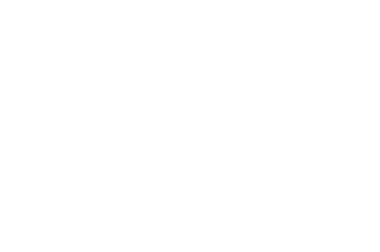

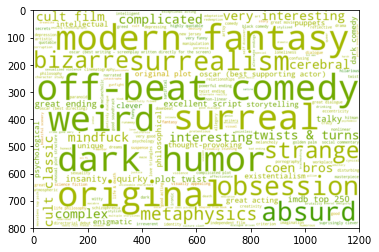

In [31]:
best_tags = get_best_tags(1)
single_movie_tags = best_tags.to_dict('records')
single_movie_tags = {pair.get('tag'):pair.get('relevance') for pair in single_movie_tags}

create_wordcloud(single_movie_tags)